In [6]:
!git clone https://github.com/domguia/thinker

Cloning into 'thinker'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 78 (delta 30), reused 62 (delta 18), pack-reused 0
Receiving objects: 100% (78/78), 610.36 KiB | 8.60 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [7]:
%cd thinker

/content/thinker/thinker


In [8]:
pip install -q torchinfo

In [ ]:
%run th1nker_run.py

In [1]:
%cd thinker

/content/thinker


In [2]:
# # number of call step for the model should be evaluated considering task scheme and memory usage
# params = dict(
#     # data param
#     batch_size = (1, 4, 8, 32),
#     input_lenght = (16, 64, 128, 256, 512, 1024),
#     output_lenght = (16, 64, 128, 256, 512, 1024),

#     # model run param
#     steps = (1, 4, 8, 16, 32, 64, 128),
#     latent = (4, 8, 16, 32, 64, 128),
#     memory_context = (16, 32, 64, 128),

#     # model weight param
#     dim = (32, 64, 128, 256, 512, 1024)
#     n_layers = (1,2,3)
#     n_heads = 8
#     # head_dim = 8
#     # hidden_dim = ()
# )


import torch
import numpy as np
from torch.utils.data import DataLoader

from thinker_model import Th1nker, compute_loss #, CfgNode
from numbers_data import NumbersComputeDataset, TASK_SCHEME

# should be defined here because of globals()
class CfgNode:
    """ a lightweight configuration class inspired by yacs """
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
    def merge_from_dict(self, d):
        self.__dict__.update(d)
    def __call__(self, *args, **kwargs):
        self.__dict__.update(**kwargs)
        args = [item.strip() for items in args for item in items.split(',')]
        self.__dict__.update(**{name: globals()[name] for name in args})
    def __str__(self):
        return self.__dict__.__str__()

cfg = CfgNode(
    hdim = 32*4,
    head_size = 4*2,
    number_of_head= 8*2,
    resid_pdrop = 0.1,
    attn_pdrop = 0.1,
    bias=False,

    vocab_size = 270,

    input_cache_size = 256,
    mem_cache_size = 2048,

    min_latent_size = 8,
    max_latent_size = 64,
    max_output_len = 256,

    min_step=4,
    max_step=16,

    probe_mode="number_reg",
    good_pred_loss_treshold=0.5,
    decay_coef=4,
)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("PyTorch device :", device)
# # cfg(vocab_size=NumbersComputeDataset.get_vocabulary_size())
model = Th1nker(cfg).to(device)

import torchinfo
print(torchinfo.summary(model))

# Optimizers specified in the torch.optim package
learing_rate=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learing_rate) #, momentum=0.9)

PyTorch device : cuda:0
Layer (type:depth-idx)                   Param #
Th1nker                                  --
├─Embedding: 1-1                         34,560
├─Embedding: 1-2                         34,560
├─Embedding: 1-3                         32,896
├─Embedding: 1-4                         8,192
├─PositionalEncoding: 1-5                --
├─Linear: 1-6                            33,024
├─Linear: 1-7                            32,768
├─Linear: 1-8                            49,152
├─LayerNorm: 1-9                         256
├─LayerNorm: 1-10                        256
├─ModuleDict: 1-11                       --
│    └─Linear: 2-1                       66,048
│    └─Linear: 2-2                       65,664
│    └─NewGELU: 2-3                      --
│    └─Dropout: 2-4                      --
├─Linear: 1-12                           129
├─Linear: 1-13                           129
├─Linear: 1-14                           34,830
Total params: 392,464
Trainable params: 392,464


In [ ]:
loss_tracker = []


   1,    6,    8,    9,    9,    8,   20, 
11.78, 11.19, 11.38, 13.71, 13.51, 12.48, 13.45, ^
0 :: loss: 0.2680 + 4.1979, n_step: 8, latent_size: 18

   7,    3,    5,    2,    5,    8,   20, 
13.56, 13.38, 11.32, 12.22, 12.59, 13.18, 13.57, ^
20 :: loss: 0.2705 + 4.1923, n_step: 6, latent_size: 50

   1,    6,   14,   13,    5,   20, 
12.81, 13.31, 12.59, 11.39, 11.99, 11.92, ^
40 :: loss: 0.2929 + 4.1745, n_step: 14, latent_size: 54

   2,    2,    3,    2,    1,    2,    1,    3,    1,   20, 
13.22, 12.10, 13.67, 12.50, 11.78, 12.52, 12.40, 14.68, 13.43, 13.20, ^
60 :: loss: 0.2646 + 4.1229, n_step: 7, latent_size: 44

   4,    9,    6,    3,    8,    1,    1,   20, 
13.71, 12.65, 12.82, 13.82, 12.49, 13.09, 13.66, 14.83, ^
80 :: loss: 0.2600 + 4.0481, n_step: 6, latent_size: 56

  12,    4,    0,   12,    2,    1,   20, 
13.70, 13.34, 13.21, 13.95, 13.83, 12.79, 12.04, ^
100 :: loss: 0.2708 + 3.9834, n_step: 10, latent_size: 64
averaged loss -> mean_prev:0.2702 mean:0.2712


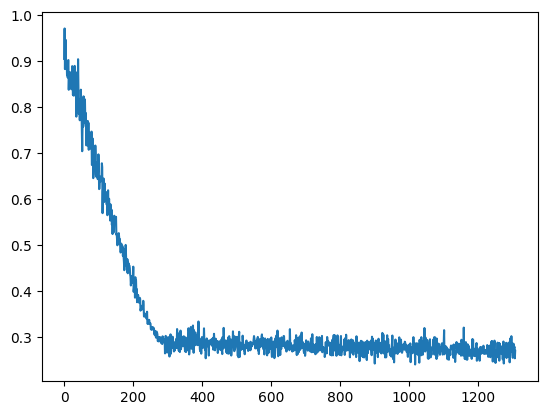

========== learing_rate: 0.0008

   3,    4,    9,    2,    3,    8,   20, 
15.01, 14.55, 14.39, 14.70, 14.09, 14.46, 14.27, ^
120 :: loss: 0.2553 + 3.7378, n_step: 9, latent_size: 20

   9,    8,    4,    6,    2,    9,   20, 
15.52, 15.22, 14.16, 15.74, 15.03, 15.84, 13.38, ^
140 :: loss: 0.3176 + 3.5783, n_step: 11, latent_size: 35
averaged loss -> mean_prev:0.2712 mean:0.2873


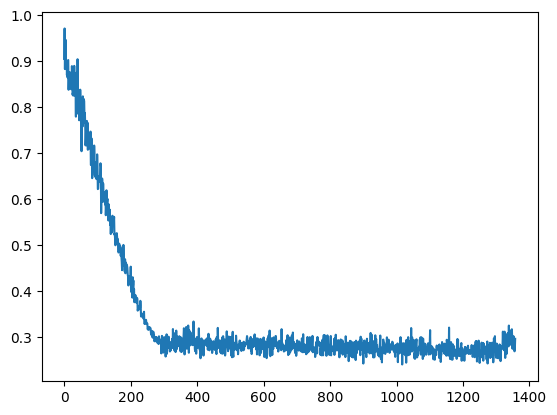

========== learing_rate: 0.0002

   4,    0,    4,    2,    8,   20, 
14.12, 14.08, 15.25, 13.27, 14.84, 14.12, ^
160 :: loss: 0.2530 + 3.3621, n_step: 8, latent_size: 39

   2,    1,    2,    3,    1,    0,    0,    2,    2,    3,   20, 
14.62, 15.63, 15.02, 16.06, 14.94, 15.03, 14.55, 15.46, 15.71, 16.38, 15.25, ^
180 :: loss: 0.2631 + 3.2366, n_step: 11, latent_size: 8

   3,    0,    4,    4,    1,    2,    1,   20, 
14.63, 16.20, 15.77, 15.42, 15.93, 15.68, 14.74, 14.89, ^
200 :: loss: 0.3009 + 3.1345, n_step: 8, latent_size: 64
averaged loss -> mean_prev:0.2873 mean:0.2917


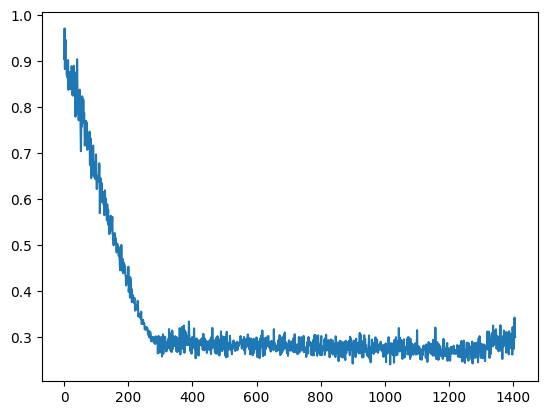

========== learing_rate: 0.0002

   0,    2,    1,    2,    2,    2,    0,    2,    3,    2,   20, 
15.69, 15.15, 16.67, 15.35, 15.73, 15.58, 16.15, 17.04, 16.78, 14.97, 16.61, ^
220 :: loss: 0.3191 + 2.9776, n_step: 12, latent_size: 26

   0,    0,    0,    0,    0,    1,    0,    0,    0,    0,    1,    1,    0,    1,    0,    0,    1,    0,    0,    1,   20, 
16.33, 15.30, 15.40, 16.32, 16.97, 17.28, 17.33, 16.87, 16.43, 15.57, 16.66, 16.85, 18.06, 17.38, 17.71, 17.12, 17.89, 16.73, 16.93, 15.68, 16.40, ^
240 :: loss: 0.3251 + 2.7812, n_step: 5, latent_size: 12
averaged loss -> mean_prev:0.2917 mean:0.3163


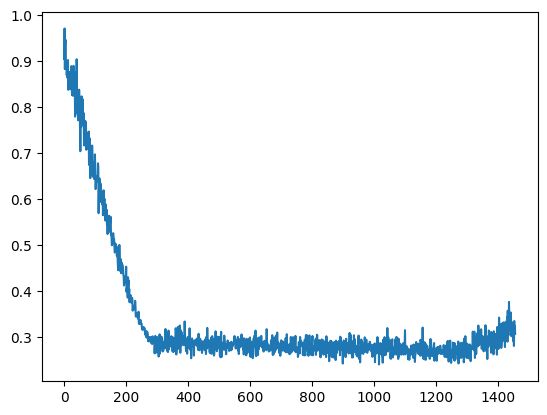

========== learing_rate: 0.0002

   2,    3,    2,    1,    3,    3,    1,    2,    1,    2,    1,   20, 
16.36, 15.64, 15.16, 16.99, 16.32, 16.02, 16.92, 17.51, 15.49, 17.27, 18.09, 15.01, ^
260 :: loss: 0.3133 + 2.6687, n_step: 15, latent_size: 27

   0,    5,    5,    7,    5,    5,   20, 
16.39, 17.24, 16.12, 16.29, 16.64, 14.64, 16.37, ^
280 :: loss: 0.2787 + 2.5762, n_step: 8, latent_size: 44

   1,    1,    1,    1,    0,    0,    1,    1,    1,    1,    1,    1,    1,    0,    0,    1,    1,    0,    1,    0,    1,   20, 
14.78, 13.68, 13.66, 14.47, 14.59, 15.24, 16.08, 15.46, 16.34, 15.43, 16.14, 16.15, 15.35, 16.04, 16.83, 14.87, 15.68, 15.32, 16.76, 15.35, 15.02, 13.37, ^
300 :: loss: 0.2336 + 2.5784, n_step: 4, latent_size: 15
averaged loss -> mean_prev:0.3163 mean:0.3105


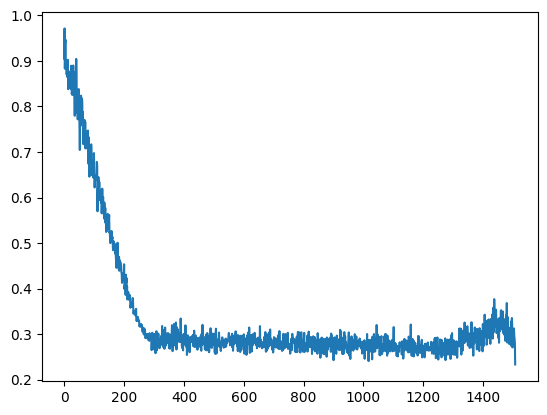

========== learing_rate: 0.0002

   8,    7,    4,    3,    0,    7,   20, 
15.32, 13.66, 13.35, 14.65, 13.96, 15.44, 14.39, ^
320 :: loss: 0.2882 + 2.5417, n_step: 13, latent_size: 8

   2,    0,    4,    1,   11,   20, 
11.33, 13.53, 13.94, 13.06, 13.00, 12.95, ^
340 :: loss: 0.2907 + 2.5271, n_step: 7, latent_size: 51
averaged loss -> mean_prev:0.3105 mean:0.2718


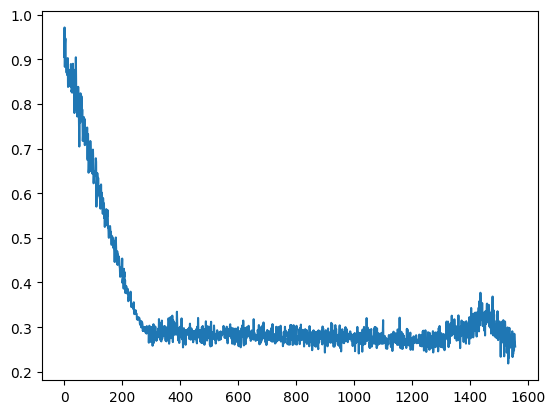

========== learing_rate: 0.0002

   0,    0,    8,    4,    9,    2,    1,   20, 
14.01, 12.75, 13.14, 13.47, 14.46, 12.39, 14.78, 14.27, ^
360 :: loss: 0.2772 + 2.4352, n_step: 15, latent_size: 27

   1,    0,    0,    0,    2,    1,    2,    1,    2,    3,   20, 
12.08, 13.03, 12.39, 12.40, 13.64, 14.01, 13.25, 15.78, 15.47, 14.18, 15.56, ^
380 :: loss: 0.2735 + 2.3507, n_step: 5, latent_size: 22

  10,    0,    8,   14,    1,    1,   20, 
14.78, 13.39, 16.19, 14.09, 15.18, 15.65, 15.84, ^
400 :: loss: 0.2669 + 2.1544, n_step: 10, latent_size: 17
averaged loss -> mean_prev:0.2718 mean:0.2707


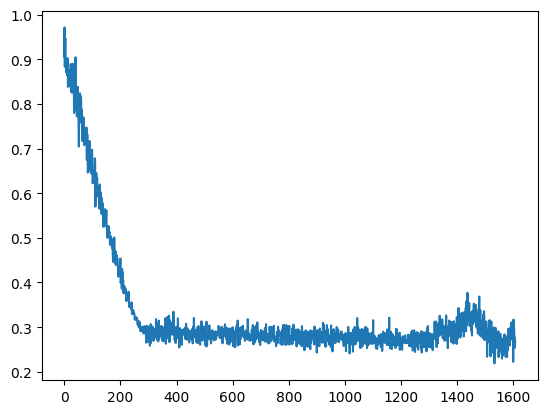

========== learing_rate: 0.0002

   5,    5,    5,    3,    1,    3,   20, 
14.77, 13.83, 14.89, 14.53, 15.98, 14.08, 16.35, ^
420 :: loss: 0.2730 + 2.0646, n_step: 7, latent_size: 32

   4,    8,    5,    1,    4,    6,    1,   20, 
14.36, 14.30, 13.52, 14.02, 13.14, 14.15, 15.04, 15.80, ^
440 :: loss: 0.3051 + 2.0334, n_step: 7, latent_size: 16
averaged loss -> mean_prev:0.2707 mean:0.2840


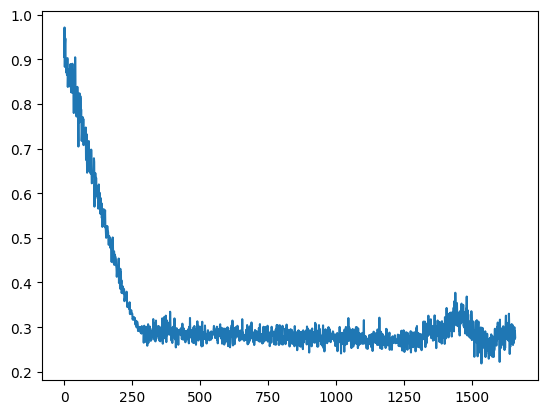

========== learing_rate: 0.0002

   0,    0,    0,    3,    3,    0,    0,    0,    2,    2,    1,   20, 
12.78, 13.24, 12.59, 13.83, 13.27, 14.23, 15.24, 14.68, 13.60, 15.00, 15.54, 15.40, ^
460 :: loss: 0.2612 + 1.9747, n_step: 4, latent_size: 34

   9,    5,    4,   14,    0,    1,   20, 
13.30, 13.84, 13.52, 12.93, 12.65, 13.71, 14.96, ^
480 :: loss: 0.2655 + 1.9208, n_step: 12, latent_size: 25

  11,    4,   12,    8,   10,    1,   20, 
12.88, 12.76, 12.04, 12.42, 11.64, 13.78, 13.88, ^
500 :: loss: 0.2616 + 1.8989, n_step: 8, latent_size: 35
averaged loss -> mean_prev:0.2840 mean:0.2678


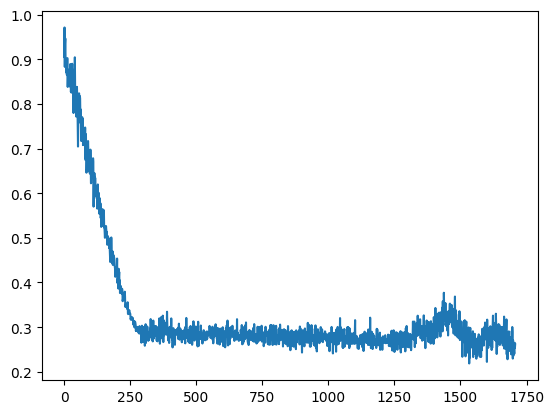

========== learing_rate: 0.0002

   2,    3,    1,    5,    2,    5,    1,   20, 
12.13, 11.97, 11.16, 12.03, 12.59, 12.30, 13.76, 14.16, ^
520 :: loss: 0.2558 + 1.8647, n_step: 12, latent_size: 43

   1,    0,    2,    1,    2,    0,    2,    3,    2,    1,   20, 
12.56, 11.49, 11.61, 10.82, 10.60, 11.28, 13.85, 13.55, 13.64, 14.50, 14.70, ^
540 :: loss: 0.2155 + 1.7876, n_step: 9, latent_size: 18
averaged loss -> mean_prev:0.2678 mean:0.2498


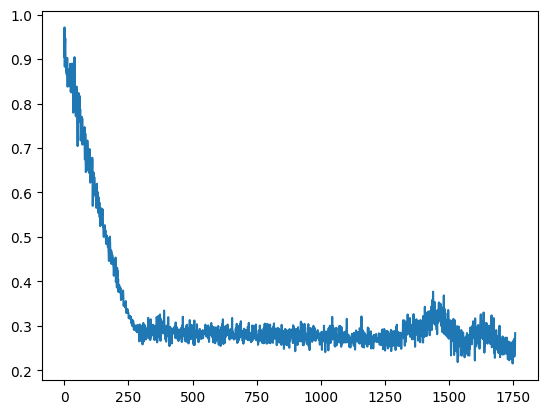

========== learing_rate: 0.0002

   3,    2,    7,    4,    2,    1,   20, 
12.27, 12.13, 12.76, 12.08, 11.81, 12.00, 13.68, ^
560 :: loss: 0.2837 + 1.7886, n_step: 11, latent_size: 53

   3,    0,    1,    7,    2,    2,   20, 
10.36, 9.49, 10.41, 10.84, 10.31, 9.26, 12.21, ^
580 :: loss: 0.2305 + 1.7711, n_step: 4, latent_size: 33

  10,    2,    2,   13,   14,   20, 
12.62, 9.74, 11.17, 12.07, 11.20, 11.59, ^
600 :: loss: 0.2352 + 1.7175, n_step: 6, latent_size: 40
averaged loss -> mean_prev:0.2498 mean:0.2419


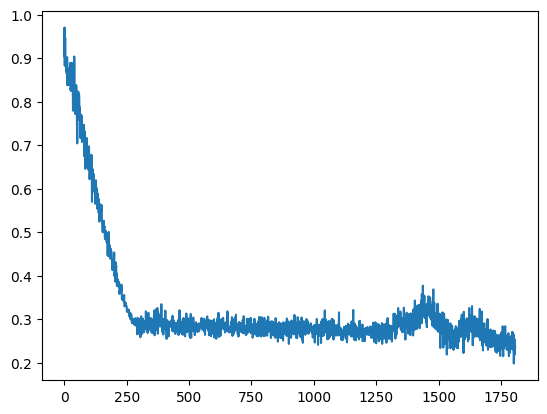

========== learing_rate: 0.0002

   3,    3,    4,    9,    6,    9,   20, 
11.77, 11.85, 12.23, 11.21, 11.46, 11.98, 13.71, ^
620 :: loss: 0.2501 + 1.6876, n_step: 13, latent_size: 28

   3,    0,    1,    0,    3,    3,    1,    0,    3,    2,   20, 
10.40, 9.39, 10.50, 10.92, 8.83, 10.97, 13.12, 14.13, 14.63, 13.77, 13.25, ^
640 :: loss: 0.2197 + 1.6562, n_step: 9, latent_size: 56
averaged loss -> mean_prev:0.2419 mean:0.2267


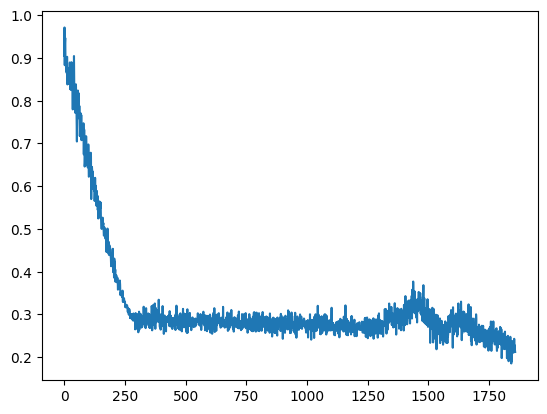

========== learing_rate: 0.0002

   3,    8,    2,   13,   12,   20, 
9.63, 8.25, 9.94, 9.76, 9.29, 9.88, ^
660 :: loss: 0.2083 + 1.6489, n_step: 9, latent_size: 22

   2,    1,    5,    3,    2,    0,    1,   20, 
10.70, 9.34, 9.59, 10.76, 9.36, 10.64, 13.90, 15.76, ^
680 :: loss: 0.2165 + 1.6113, n_step: 10, latent_size: 28

   2,    1,    3,    3,    1,    2,    1,    3,    0,    2,    1,   20, 
9.40, 8.17, 8.38, 8.84, 8.59, 8.64, 12.81, 15.23, 14.61, 15.49, 15.01, 14.69, ^
700 :: loss: 0.1749 + 1.5676, n_step: 11, latent_size: 10
averaged loss -> mean_prev:0.2267 mean:0.2039


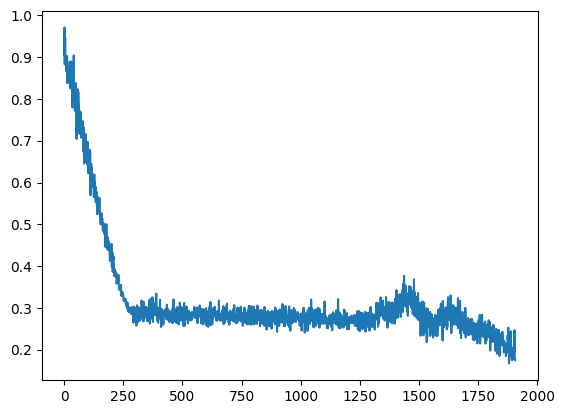

========== learing_rate: 0.0002

   1,    0,    1,    1,    1,    1,    0,    1,    0,    1,    0,    0,    0,    1,    1,    1,    0,    0,    1,    1,    1,   20, 
10.54, 8.20, 8.39, 8.90, 9.36, 9.11, 14.33, 15.36, 15.51, 16.11, 17.46, 15.55, 15.21, 15.37, 15.82, 14.73, 16.06, 16.59, 15.81, 14.80, 14.23, 11.87, ^
720 :: loss: 0.1772 + 1.5651, n_step: 9, latent_size: 44

   3,    1,    3,    1,    3,    3,    2,    3,    2,    2,    1,   20, 
7.94, 6.65, 7.03, 7.81, 7.59, 8.63, 13.17, 15.40, 16.42, 15.71, 16.15, 16.45, ^
740 :: loss: 0.1994 + 1.6334, n_step: 8, latent_size: 61
averaged loss -> mean_prev:0.2039 mean:0.1851


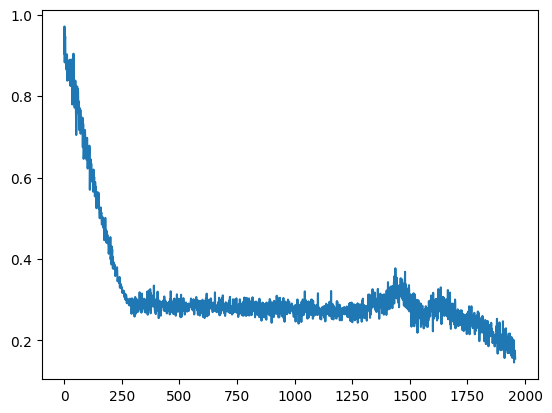

========== learing_rate: 0.0002

   2,    0,    2,    2,    3,    3,    0,    3,    3,    0,    1,   20, 
6.83, 6.77, 5.14, 5.40, 5.72, 7.50, 12.51, 15.35, 16.28, 15.39, 16.51, 17.79, ^
760 :: loss: 0.1624 + 1.6070, n_step: 10, latent_size: 12

   3,    3,    5,    6,    5,    5,   20, 
6.01, 4.26, 4.62, 6.45, 5.22, 6.74, 12.87, ^
780 :: loss: 0.1676 + 1.6723, n_step: 5, latent_size: 17

   1,    7,   15,    8,    6,    1,   20, 
6.10, 5.23, 6.50, 6.41, 5.61, 6.94, 14.74, ^
800 :: loss: 0.1506 + 1.5444, n_step: 7, latent_size: 34
averaged loss -> mean_prev:0.1851 mean:0.1739


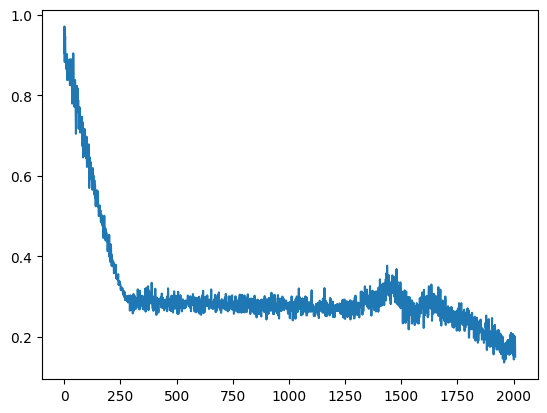

========== learing_rate: 0.0002

  15,    2,    8,    0,    7,   20, 
6.39, 5.00, 5.45, 6.93, 5.90, 8.05, ^
820 :: loss: 0.1867 + 1.6207, n_step: 6, latent_size: 49

   0,    4,   11,    1,   10,   20, 
8.85, 8.83, 7.71, 8.13, 6.85, 10.09, ^
840 :: loss: 0.2006 + 1.5426, n_step: 13, latent_size: 41
averaged loss -> mean_prev:0.1739 mean:0.1772


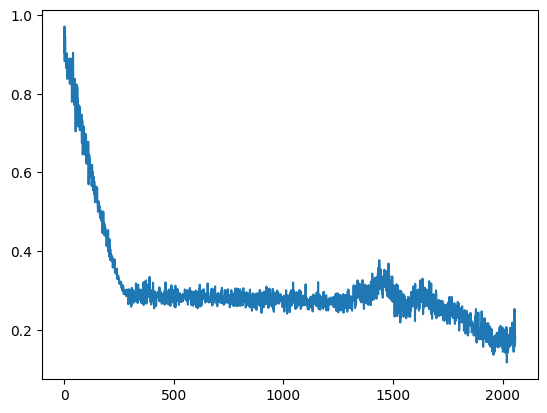

========== learing_rate: 0.0002

   0,    0,    3,    2,    0,    0,    1,    1,    2,    2,   20, 
6.67, 4.31, 5.64, 6.91, 5.90, 8.46, 14.37, 18.48, 17.70, 18.59, 16.83, ^
860 :: loss: 0.1773 + 1.5817, n_step: 6, latent_size: 48

   2,    1,    2,    3,    1,    2,    3,    1,    1,    3,   20, 
5.36, 4.66, 4.39, 5.20, 4.76, 6.67, 12.74, 15.74, 16.28, 16.30, 18.21, ^
880 :: loss: 0.1771 + 1.5870, n_step: 7, latent_size: 17

   3,    2,    1,    3,    3,    1,    3,    1,    0,    2,    1,   20, 
6.31, 6.14, 5.62, 5.76, 5.06, 7.52, 13.17, 17.80, 17.11, 17.10, 16.72, 16.94, ^
900 :: loss: 0.1614 + 1.5363, n_step: 4, latent_size: 49
averaged loss -> mean_prev:0.1772 mean:0.1724


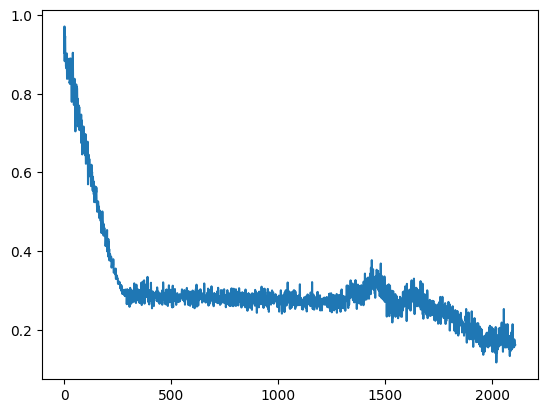

========== learing_rate: 0.0002

   1,    1,    1,    0,    1,    1,    0,    1,    1,    0,    1,    0,    1,    1,    1,    0,    1,    0,    1,    1,   20, 
7.83, 7.05, 8.07, 7.50, 7.65, 9.18, 12.89, 16.16, 15.84, 14.99, 17.75, 16.20, 16.75, 15.70, 16.62, 16.57, 17.51, 17.98, 18.64, 16.38, 11.76, ^
920 :: loss: 0.1682 + 1.4765, n_step: 12, latent_size: 61

   6,    8,    8,    8,    0,    3,    1,   20, 
6.80, 6.99, 6.96, 5.70, 5.94, 9.27, 11.43, 17.49, ^
940 :: loss: 0.1876 + 1.5504, n_step: 7, latent_size: 31
averaged loss -> mean_prev:0.1724 mean:0.1770


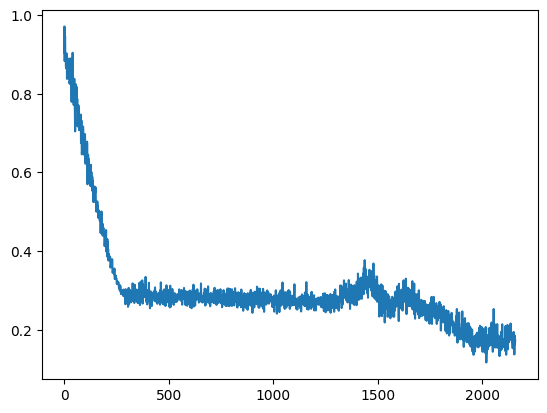

========== learing_rate: 0.0002

   1,    1,    0,    0,    0,    0,    1,    1,    0,    1,    0,    0,    0,    0,    1,    1,    0,    1,    1,   20, 
6.84, 6.45, 6.73, 6.25, 6.18, 8.24, 11.27, 16.00, 15.65, 15.30, 16.44, 19.15, 17.36, 15.37, 17.52, 17.24, 16.13, 17.91, 17.44, 14.97, ^
960 :: loss: 0.1813 + 1.5291, n_step: 9, latent_size: 30

   0,    0,    1,    1,    1,    1,    1,    0,    1,    1,    0,    1,    1,    0,    1,    0,    0,    0,    1,   20, 
5.71, 5.83, 6.59, 5.97, 6.11, 9.04, 13.31, 15.47, 16.34, 15.07, 17.48, 16.97, 15.36, 16.29, 17.60, 16.13, 16.33, 16.96, 16.25, 16.44, ^
980 :: loss: 0.1976 + 1.5394, n_step: 5, latent_size: 23

   2,   10,    3,    4,    3,    1,   20, 
8.18, 7.18, 7.10, 7.43, 6.75, 8.58, 13.37, ^
1000 :: loss: 0.1832 + 1.4928, n_step: 13, latent_size: 26
averaged loss -> mean_prev:0.1770 mean:0.1749


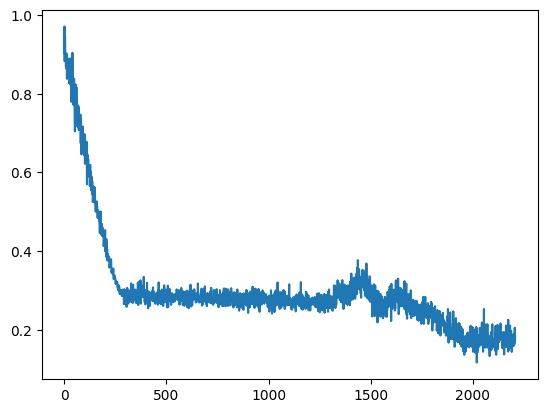

========== learing_rate: 0.0002

   2,    2,    2,    2,    0,    2,    3,    1,    0,    0,    1,   20, 
5.01, 7.16, 5.05, 5.60, 5.33, 6.03, 11.04, 15.87, 16.84, 15.76, 15.77, 16.20, ^
1020 :: loss: 0.1640 + 1.4868, n_step: 7, latent_size: 18

   7,    5,    9,    7,    0,    3,   20, 
5.82, 5.85, 5.90, 6.21, 6.44, 7.87, 11.20, ^
1040 :: loss: 0.1653 + 1.4661, n_step: 8, latent_size: 32
averaged loss -> mean_prev:0.1749 mean:0.1704


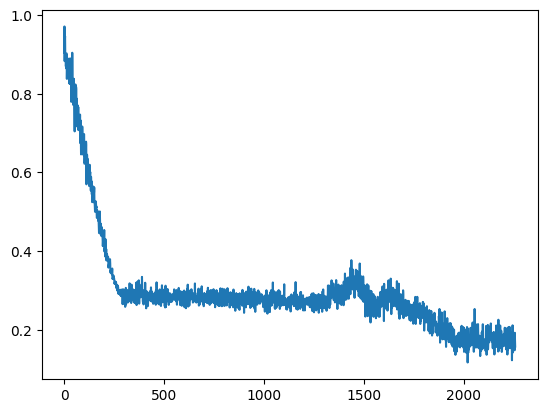

========== learing_rate: 0.0002

   0,    0,    0,    1,    1,    0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    1,    1,    0,    1,    0,    1,   20, 
6.55, 6.75, 6.66, 7.05, 7.14, 9.62, 11.55, 15.04, 16.77, 15.50, 16.10, 17.61, 16.74, 17.07, 16.73, 17.00, 15.57, 17.23, 16.37, 14.78, 11.79, 13.02, ^
1060 :: loss: 0.2026 + 1.5076, n_step: 12, latent_size: 36

  13,   14,    9,    0,    8,   20, 
7.12, 6.38, 5.33, 6.22, 5.83, 7.88, ^
1080 :: loss: 0.1669 + 1.4797, n_step: 8, latent_size: 15

   1,    3,    1,    1,    6,   20, 
5.85, 6.48, 6.62, 6.38, 5.80, 9.08, ^
1100 :: loss: 0.2187 + 1.5315, n_step: 13, latent_size: 48
averaged loss -> mean_prev:0.1704 mean:0.1676


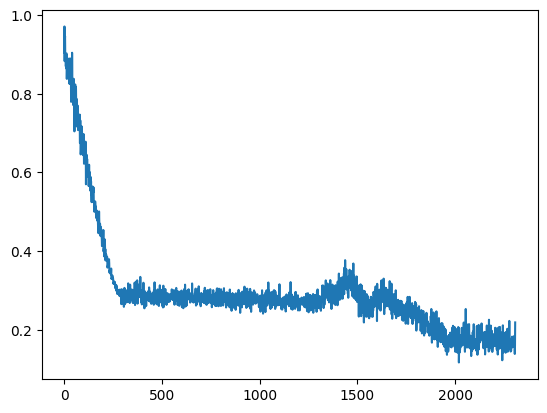

========== learing_rate: 0.0002

   1,    1,    1,    0,    0,    1,    0,    0,    0,    0,    1,    0,    1,    1,    1,    1,    0,    1,    1,   20, 
7.54, 6.70, 5.35, 7.15, 5.49, 8.10, 9.73, 16.46, 16.15, 16.13, 15.47, 15.13, 15.84, 16.75, 16.28, 17.35, 16.55, 16.90, 18.56, 16.22, ^
1120 :: loss: 0.1281 + 1.3748, n_step: 13, latent_size: 22

  12,    1,    8,    3,    3,    1,   20, 
5.50, 4.94, 5.51, 5.47, 3.73, 7.99, 14.17, ^
1140 :: loss: 0.1526 + 1.4434, n_step: 8, latent_size: 13
averaged loss -> mean_prev:0.1676 mean:0.1704


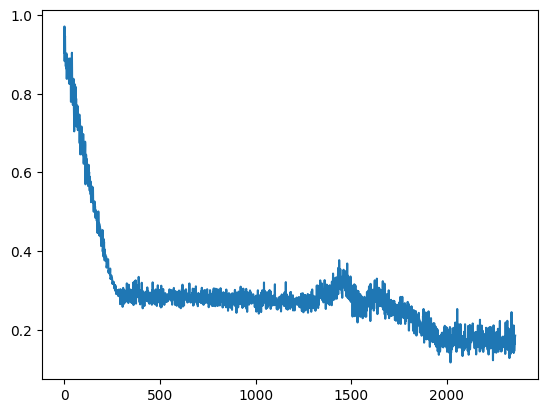

========== learing_rate: 0.0002

   1,    0,    3,    2,    3,    0,    3,    3,    3,    3,   20, 
5.72, 5.48, 6.33, 5.68, 6.37, 9.71, 13.67, 18.15, 16.78, 16.05, 17.21, ^
1160 :: loss: 0.1732 + 1.4626, n_step: 4, latent_size: 47

   9,    7,   13,   14,   14,   20, 
5.60, 5.63, 4.56, 6.20, 5.73, 7.94, ^
1180 :: loss: 0.1268 + 1.3907, n_step: 5, latent_size: 61

   1,    1,    3,    1,    0,    0,    3,    3,    1,    3,   20, 
5.55, 5.78, 4.49, 5.89, 6.05, 7.65, 11.00, 15.28, 15.94, 15.18, 15.71, ^
1200 :: loss: 0.1398 + 1.4003, n_step: 11, latent_size: 28
averaged loss -> mean_prev:0.1704 mean:0.1682


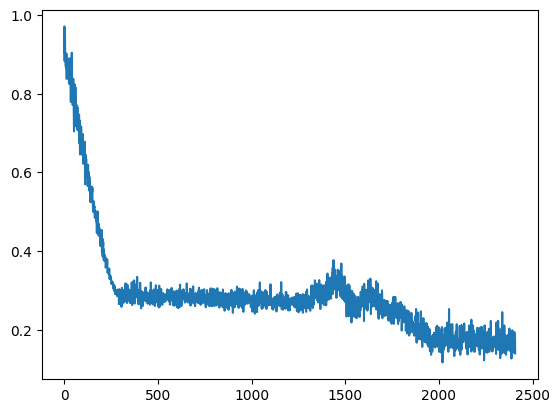

========== learing_rate: 0.0002

   0,    0,    0,    0,    0,    1,    1,    1,    0,    0,    0,    1,    1,    1,    0,    1,    1,    1,    0,    1,   20, 
4.87, 5.47, 5.43, 5.85, 5.76, 7.35, 11.01, 15.94, 15.00, 14.94, 16.50, 18.47, 17.13, 17.17, 17.29, 14.58, 16.68, 17.06, 18.85, 15.81, 12.82, ^
1220 :: loss: 0.1775 + 1.4513, n_step: 14, latent_size: 45

   5,    2,    9,    6,    6,    9,   20, 
5.70, 4.71, 4.67, 5.81, 5.75, 6.95, 11.21, ^
1240 :: loss: 0.1488 + 1.4215, n_step: 8, latent_size: 38
averaged loss -> mean_prev:0.1682 mean:0.1634


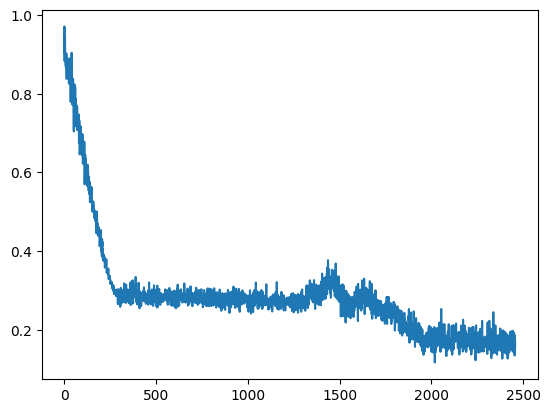

========== learing_rate: 0.0002

   8,    1,    6,    1,    3,    1,    1,   20, 
4.43, 5.28, 5.60, 5.11, 5.51, 6.82, 10.37, 17.16, ^
1260 :: loss: 0.1480 + 1.4123, n_step: 12, latent_size: 11

   1,    1,    3,    3,    3,    0,    1,    3,    0,    3,   20, 
4.87, 6.50, 6.22, 4.55, 5.19, 7.25, 13.41, 15.41, 17.13, 15.18, 18.59, ^
1280 :: loss: 0.1599 + 1.4294, n_step: 7, latent_size: 53


KeyboardInterrupt: ignored

In [5]:
dataset = NumbersComputeDataset(TASK_SCHEME)
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4)

optimizer.zero_grad()

for idx, (inputs,targets) in enumerate(dataloader):
    inputs,targets = inputs.to(device), targets.to(device)
    batch_size = inputs.size(0)

    logs = CfgNode()
    logs('batch_size')

    n_step = np.random.randint(cfg.min_step, cfg.max_step)
    # m_step = np.random.randint(1, n_step)
    logs('n_step')

    # #### stop gradient run
    # with torch.no_grad():
    #     for _ in range(m_step):
    #         model.compute_step()
    # for _ in range(m_step, n_step-1):
    #     model.compute_step()

    #### full run with gradient

    latent_size = np.random.randint(cfg.min_latent_size, cfg.max_latent_size+1)

    with torch.device(device):
        model.init(batch_size, latent_size)
        model.load_input(inputs)
    # logs('batch_size, n_step')

    losses = []
    for i in range(n_step-1):
        with torch.device(device):
            model.compute_step()
        # model.compute_step(with_output=targets.size(1))
        # # output = model.compute_step(with_output=y) #causal
        # output = model.get_output() #parallel
        # loss = compute_loss(output, targets, cfg.probe_m1024ode)
        # losses.append(loss)

    with torch.device(device):
        model.compute_step(with_output=targets.size(1))
        output = model.get_output()
        loss = compute_loss(output, targets, cfg.probe_mode)

    for break_i in range(targets.size(1)-1,-1,-1):
        if targets[:,break_i].float().mean() < 20: break

    if idx%20==0:
        print()
        probe, logits, outputs_probe = output
        for i in range(targets.size(1)):
            val = targets[0,i].item()
            print(f"{val:4d}", end=', ')
            if val == 20: break
        print()
        for j in range(i+1):
            val = outputs_probe[0,j].item()*16
            print(f"{val:.2f}", end=', ')
        print('^')

    # losses.append(loss)

    # n = len(losses)
    # # losses = torch.Tensor(losses)
    # # losses = list(map(list, zip(*losses)))
    # # losses = [list(filter(lambda x: x, col)) for col in zip(*losses)]
    # losses = list(map(lambda x: torch.stack(list(x)).transpose(1,0), zip(*losses)))
    # _, probe_loss, pred_loss, _, outputs_probe_losses = losses

    # ## more weight to the good and llast loss
    # ## without neglecting the first lower quality
    # ## so that the model will value progress in early step
    # ## while give more importance to last/good one
    # good_ = pred_loss > cfg.good_pred_loss_treshold
    # coef_ = good_.clone()
    # good_pred_ratio = good_.sum(dim=1)/n
    # # coef_[good_] = 0.5/good_.sum(dim=1)
    # # coef_[~good_] = 0.5/(n-sum(good_))
    # coef_ = torch.where(good_,0.5/good_.sum(dim=1)[:,None],0.5/(n-good_.sum(dim=1)[:,None]))

    # ## decay coefficient followed steps
    # coef_decay = (cfg.decay_coef*torch.arange(n)/n).softmax(dim=0)
    # coef_ = coef_ * coef_decay

    # loss_1 = (probe_loss * coef_).mean()
    # loss_2 = (outputs_probe_losses * coef_ * coef_decay).mean()
    # loss_3 = (pred_loss * coef_).mean()
    # loss = loss_1 + loss_2 + loss_3

    # probe_loss, pred_loss, outputs_probe_losses = probe_loss[:,-1].mean().item(), outputs_probe_losses[:,-1].mean().item(), pred_loss[:,-1].mean().item()
    # logs('probe_loss, pred_loss, outputs_probe_losses')
    # probe_loss, pred_loss, outputs_probe_losses = probe_loss.mean().item(), outputs_probe_losses.mean().item(), pred_loss.mean().item()


    # print(f"loss {loss:.4f}, good pred : {good_pred_ratio:.4f} = {sum(good_)} / {n} preds over 0.5 treshold")

    _, probe_loss, pred_loss, output_losses, outputs_probe_losses = loss

    # loss = probe_loss + pred_loss[:,None] + outputs_probe_losses
    # targets < 20
    output_loss = output_losses[:,:break_i].mean()
    outputs_probe_loss = outputs_probe_losses[:,:break_i].mean()
    # ((output_loss + outputs_probe_loss*16*4)*n_step/cfg.max_step).backward()
    ((output_loss + outputs_probe_loss*16/4)*n_step/cfg.max_step).backward()

    if idx%10==0:
        optimizer.step()
        optimizer.zero_grad()

    if idx%20==0:
        print(f"{idx} :: loss: {outputs_probe_loss.item():.4f} + {output_loss.item():.4f}, n_step: {n_step}, latent_size: {latent_size}")

    # logs('probe_loss, pred_loss, outputs_probe_losses')
    # logs('good_pred_ratio,loss')
    # print(logs)

    loss_tracker.append(outputs_probe_loss.item())

    if idx%50==0 and idx>=100:
        mean = np.mean(loss_tracker[-50:])
        mean_prev = np.mean(loss_tracker[-100:-50])

        print(f'averaged loss -> mean_prev:{mean_prev:.4f} mean:{mean:.4f}')
        # lr = learing_rate * max(np.abs(mean-mean_prev), 100/idx)

        import matplotlib.pyplot as plt
        plt.plot(loss_tracker[10:])
        plt.savefig("loss.png")
        plt.show()

        with open('./train_param.txt','r') as f:
            lr = float(f.read())*learing_rate

        print('========== learing_rate:', lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # if idx%100==0:
        #     torch.save(model, "model.pck")

    # if idx == 1000:
    #     lr = learing_rate * 0.1
    #     print('learing_rate:', lr)
    #     # lr = float(input('Learning new rate: '))
    #     for param_group in optimizer.param_groups:
    #         param_group['lr'] = lr
    # break
